## 2.1 Meta-population Model

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint

In [25]:
np.random.seed(8)

X_initial = 300
Y_initial = 1
Z_initial = 0

t_end = 20
beta = 2
gamma = 1/2
rho = 1
rho12 = 0.01
rho21 = 0.01


def meta_pop2(n, rho12, rho21):
    
    results = []
    
    for i in range(n):
    
    # Set initial numbers
        X1 = [X_initial]
        Y1 = [Y_initial]
        Z1 = [Z_initial]

        X2 = [X_initial]
        Y2 = [0]
        Z2 = [Z_initial]        
        
        t = [0]

        while t[-1] < t_end:
            
            X1now = X1[-1]
            Y1now = Y1[-1]
            Z1now = Z1[-1]
            N1now = X1now + Y1now + Z1now
            X2now = X2[-1]
            Y2now = Y2[-1]
            Z2now = Z2[-1]
            N2now = X2now + Y2now + Z2now            
            
            if X1now == 0 and X2now ==0:
                break
            if Y1now == 0 and Y2now ==0:
                break
            
            rate1_tra = beta * (rho * Y1now / N1now + rho12 * Y2now / N1now) * X1now
            rate1_rec = gamma * Y1now
            
            rate2_tra = beta * (rho * Y2now / N2now + rho21 * Y1now / N2now) * X2now
            rate2_rec = gamma * Y2now
            
            rates = [rate1_tra, rate1_rec, rate2_tra, rate2_rec]
            
            rates_sum = sum(rates)
                        
            dt = (-1 / rates_sum) * math.log(np.random.uniform(0,1))

            t.append(t[-1] + dt)

            rand = np.random.uniform(0,1)
            p = rand * rates_sum

            # Transmission 11
            if p < rates[0]:
                X1.append(X1[-1] - 1)
                Y1.append(Y1[-1] + 1)
                Z1.append(Z1[-1])
                
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])
            # Recovery
            elif p > rates[0] and p <= sum(rates[:2]):
                X1.append(X1[-1])
                Y1.append(Y1[-1] - 1)
                Z1.append(Z1[-1] + 1)
                
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])

            # Transmission2
            elif p > sum(rates[:2]) and p <= sum(rates[:3]):
                X2.append(X2[-1] - 1)
                Y2.append(Y2[-1] + 1)
                Z2.append(Z2[-1])
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
            # Recovery2
            elif p > sum(rates[:3]) and p <= rates_sum:
                X2.append(X2[-1])
                Y2.append(Y2[-1] - 1)
                Z2.append(Z2[-1] + 1)
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
                
        df = pd.DataFrame(
            {
                'X1': X1,
                'Y1': Y1,
                'Z1': Z1,   
                'X2': X2,
                'Y2': Y2,
                'Z2': Z2                 
            },index = t
        )
        results.append(df)
    return results

def interpolate_meta2(n, results):
    df_Y = pd.DataFrame()
    for i in range(n):
        idf = results[i]
        interval = np.linspace(0,t_end,t_end * 10)
        new_index = np.concatenate((idf.index, interval[1:]), axis=None)
        idf1 = idf.reindex(new_index).sort_index()
        idf2 = idf1.interpolate(method = 'index')
        idf3 = idf2.loc[interval,:]
        
        df1 = pd.DataFrame({
            't': interval,
            'Y': idf3['Y1'],
            'Population': ['Sub 1'] * len(interval)
        })
        df2 = pd.DataFrame({
            't': interval,
            'Y': idf3['Y2'],
            'Population': ['Sub 2'] * len(interval)
        })
        df_Y = df_Y.append(df1, ignore_index=True)
        df_Y = df_Y.append(df2, ignore_index=True)
    return df_Y

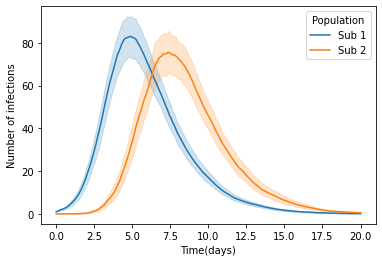

In [26]:
results = meta_pop2(100, rho12, rho21)
data2 = interpolate_meta2(100, results)

plot = sns.lineplot(x = "t", y = "Y",
             hue = "Population",
             data = data2)
plot.set(xlabel='Time(days)', ylabel='Number of infections')
fig = plot.get_figure()
fig.savefig('part2_metapopulation_2_subs.png', dpi=400)

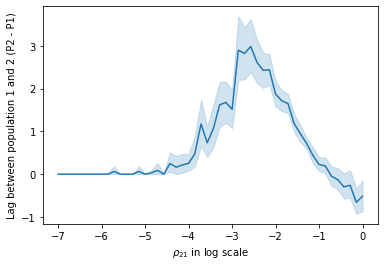

In [27]:
intervals = np.linspace(-7, 0, 50, dtype=float)
df_lag = pd.DataFrame()
for i in intervals:
    rho21 = np.power(10,i)
    results = meta_pop2(100, 0, rho21)
    t1s = []
    t2s = []
    lags = []
    for df in results:
        idx = df.idxmax()
        t1 = idx['Y1']
        t2 = idx['Y2']
        if t2 == 0:
            lag = 0
            lags.append(lag)
            t1s.append(t1)
            t2s.append(t2)
        else:
            lag = t2 - t1
            lags.append(lag)
            t1s.append(t1)
            t2s.append(t2)
    idf = pd.DataFrame({
            'rho21': i,
            'lag': lags,
            't1': t1s,
            't2': t2s
        })
    df_lag = df_lag.append(idf, ignore_index=True)
    
fig, ax = plt.subplots()
sns.lineplot(x = "rho21", y = "lag", ax = ax, data = df_lag)
ax.set_xlabel(r'$\rho_{21}$ in log scale')
ax.set_ylabel('Lag between population 1 and 2 (P2 - P1)')
fig.savefig('part2_lag.png', dpi=400)

In [28]:
X_initial = 300
Y_initial = 1
Z_initial = 0

t_end = 20
beta = 2
gamma = 1/2
rho = 1
rho12 = 0.01
rho13 = 0.01
rho21 = 0.01
rho23 = 0.01
rho31 = 0.2
rho32 = 0.01

def meta_pop3(n):
    
    results = []
    
    for i in range(n):
    
    # Set initial numbers
        X1 = [X_initial]
        Y1 = [Y_initial]
        Z1 = [Z_initial]

        X2 = [X_initial]
        Y2 = [0]
        Z2 = [Z_initial]
        
        X3 = [X_initial]
        Y3 = [0]
        Z3 = [Z_initial]  
        
        t = [0]

        while t[-1] < t_end:
            
            X1now = X1[-1]
            Y1now = Y1[-1]
            Z1now = Z1[-1]
            N1now = X1now + Y1now + Z1now
            X2now = X2[-1]
            Y2now = Y2[-1]
            Z2now = Z2[-1]
            N2now = X2now + Y2now + Z2now
            X3now = X3[-1]
            Y3now = Y3[-1]
            Z3now = Z3[-1]
            N3now = X3now + Y3now + Z3now  
            
            if X1now == 0 and X2now and X3now ==0:
                break
            if Y1now == 0 and Y2now ==0 and Y3now == 0:
                break
            
            rate1_tra = beta * (rho * Y1now / N1now + rho12 * Y2now / N1now + rho13 * Y3now / N1now) * X1now
            rate1_rec = gamma * Y1now
            
            rate2_tra = beta * (rho * Y2now / N2now + rho21 * Y1now / N2now + rho23 * Y3now / N2now) * X2now
            rate2_rec = gamma * Y2now
            
            rate3_tra = beta * (rho * Y3now / N3now + rho31 * Y1now / N3now + rho32 * Y2now / N3now) * X3now
            rate3_rec = gamma * Y3now
            
            rates = [rate1_tra, rate1_rec, rate2_tra, rate2_rec, rate3_tra, rate3_rec]
            
            rates_sum = sum(rates)
            
            dt = (-1 / rates_sum) * math.log(np.random.uniform(0,1))

            t.append(t[-1] + dt)

            rand = np.random.uniform(0,1)
            p = rand * rates_sum

            # Transmission 1
            if p < rates[0]:
                X1.append(X1[-1] - 1)
                Y1.append(Y1[-1] + 1)
                Z1.append(Z1[-1])
                
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])
                X3.append(X3[-1])
                Y3.append(Y3[-1])
                Z3.append(Z3[-1])
                
            # Recovery 1
            elif p > rates[0] and p <= sum(rates[:2]):
                X1.append(X1[-1])
                Y1.append(Y1[-1] - 1)
                Z1.append(Z1[-1] + 1)
                
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])
                X3.append(X3[-1])
                Y3.append(Y3[-1])
                Z3.append(Z3[-1])

            # Transmission 2
            elif p > sum(rates[:2]) and p <= sum(rates[:3]):
                X2.append(X2[-1] - 1)
                Y2.append(Y2[-1] + 1)
                Z2.append(Z2[-1])
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
                X3.append(X3[-1])
                Y3.append(Y3[-1])
                Z3.append(Z3[-1])

            # Recovery 2
            elif p > sum(rates[:3]) and p <= sum(rates[:4]):
                X2.append(X2[-1])
                Y2.append(Y2[-1] - 1)
                Z2.append(Z2[-1] + 1)
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
                X3.append(X3[-1])
                Y3.append(Y3[-1])
                Z3.append(Z3[-1])

            
            # Transmission 2
            elif p > sum(rates[:4]) and p <= sum(rates[:5]):
                X3.append(X3[-1] - 1)
                Y3.append(Y3[-1] + 1)
                Z3.append(Z3[-1])
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])
                
            # Recovery 2
            elif p > sum(rates[:5]) and p <= rates_sum:
                X3.append(X3[-1])
                Y3.append(Y3[-1] - 1)
                Z3.append(Z3[-1] + 1)
                
                X1.append(X1[-1])
                Y1.append(Y1[-1])
                Z1.append(Z1[-1])
                X2.append(X2[-1])
                Y2.append(Y2[-1])
                Z2.append(Z2[-1])
                
        df = pd.DataFrame(
            {
                'X1': X1,
                'Y1': Y1,
                'Z1': Z1,   
                'X2': X2,
                'Y2': Y2,
                'Z2': Z2,
                'X3': X3,
                'Y3': Y3,
                'Z3': Z3
            },index = t
        )
        results.append(df)
    return results

def interpolate_meta3(n, results):
    df_Y = pd.DataFrame()
    for i in range(n):
        idf = results[i]
        interval = np.linspace(0,t_end,t_end * 10)
        new_index = np.concatenate((idf.index, interval[1:]), axis=None)
        idf1 = idf.reindex(new_index).sort_index()
        idf2 = idf1.interpolate(method = 'index')
        idf3 = idf2.loc[interval,:]
        
        df1 = pd.DataFrame({
            't': interval,
            'Y': idf3['Y1'],
            'Population': ['Sub 1'] * len(interval)
        })
        df2 = pd.DataFrame({
            't': interval,
            'Y': idf3['Y2'],
            'Population': ['Sub 2'] * len(interval)
        })
        df3 = pd.DataFrame({
            't': interval,
            'Y': idf3['Y3'],
            'Population': ['Sub 3'] * len(interval)
        })
        df_Y = df_Y.append(df1, ignore_index=True)
        df_Y = df_Y.append(df2, ignore_index=True)
        df_Y = df_Y.append(df3, ignore_index=True)
        
    return df_Y

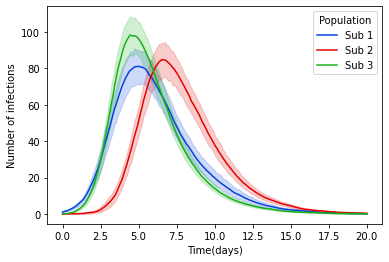

In [29]:
results = meta_pop3(100)
data3 = interpolate_meta3(100, results)

plot = sns.lineplot(x = "t", y = "Y",
             hue = "Population",
             data = data3, palette = ['xkcd:blue','xkcd:red','xkcd:green'])
plot.set(xlabel='Time(days)', ylabel='Number of infections')
fig = plot.get_figure()
fig.savefig('part2_metapopulation_3_subs.png', dpi=400)